In [ ]:
import torch
from PIL import Image
import glob
import torchvision
import cv2
import random
import matplotlib.pyplot as plt
import torch.nn as nn
#from scipy.stats import wasserstein_distance`
import torch.nn.functional as F
import progressbar
from sklearn import metrics
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
import random
import requests
import os
import time
import json
import gc
from torchsummary import summary
import pycuda.driver as cuda
from io import StringIO,BytesIO

C:\Users\MOHIT\anaconda3\envs\deepLeArning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\MOHIT\anaconda3\envs\deepLeArning\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
classes = ['bus', 'pizza', 'cat']
img_annotations_train = json.load(open('train_annotations.json'))
print(f"Number of Training Images {len(img_annotations_train)}")
img_annotations_val = json.load(open('val_annotations.json'))
print(f"Number of Testing Images {len(img_annotations_val)}")

Number of Training Images 6192
Number of Testing Images 3177


In [ ]:
"""for x in img_annotations_train:
    obj = x['objects']
    if len(obj)>2:
        print(x)"""

"for x in img_annotations_train:\n    obj = x['objects']\n    if len(obj)>2:\n        print(x)"

In [ ]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self,root,img_annotations,cell_length, category_to_OHE , anchor_boxes):
        """
        root : directory of the images
        """
        super().__init__()
        self.preprocess = torchvision.transforms.Compose([
        #tvt.ToPILImage(),
        torchvision.transforms.ToTensor(),
        #tvt.Normalize([0,0,0],[1,1,1])
        ])
        self.img_attr = img_annotations
        self.data = []
        #self.root = "/content/drive/MyDrive/Deep_Learning/HW5/"+ root
        self.root =  root
        #self.classes = classes
        #self.read_images()
        self.labels = category_to_OHE
        self.cell_length = cell_length
        self.num_cells = int(256/cell_length)
        self.anchor_boxes = anchor_boxes
        print(f"Number of cells in row and col = {self.num_cells}")
        print(f"Cell length = {self.cell_length}")
        print(f"Number of total yolo cells = {self.num_cells**2}")
        

    def __len__(self):
        return len(self.img_attr)

    def __getitem__(self,index):
        image = Image.open(f"{self.root}/{self.img_attr[index]['img_id']}.jpg")
        img_np =  np.array(image)
        flag=False
        if img_np.ndim == 2:
            #print(f"{index} : B & W")
            rgbimg = Image.new("RGB", image.size)
            rgbimg.paste(image)
            image = rgbimg
            #flag=True
        yolo_tensor = torch.zeros(self.num_cells, self.num_cells,len(self.anchor_boxes) , (len(self.labels)+5))
        
        #print(f"yolo_tensor = {yolo_tensor}")
        #print(f"yolo_tensor shape = {yolo_tensor.shape}")
        cell_length = self.cell_length 
        objects = self.img_attr[index]['objects']
        image_tensor = self.preprocess(image).float()
        for object1 in objects:
            bbox = object1['b_box'] # top left x , y , w, h 
            label = self.labels[object1['category_id']]
            #self.labels[self.class_str_to_num[self.img_attr[index]['class']]]

            b_box_center_x , b_box_center_y = [bbox[0] + bbox[2]/2 , bbox[1]+bbox[3]/2]
            #print(b_box_center_x , b_box_center_y)
            
            
            # getting the cell index
            cell_x , cell_y = [self.find_cell_number(b_box_center_x,self.num_cells,cell_length) , self.find_cell_number(b_box_center_y,self.num_cells,cell_length)]
            if cell_x == None:
                print(b_box_center_x)
                _ = self.find_cell_number(b_box_center_x,self.num_cells, True) 
            if cell_y == None:
                print(b_box_center_y)
                _ = self.find_cell_number(b_box_center_y,self.num_cells, True) 
            #print(cell_x , cell_y)
            
            
            # getting the anchor box index
            all_ious = [self.iou_width_height(anchor_box,(bbox[2],bbox[3])) for anchor_box in self.anchor_boxes]
            #print(all_ious)
            #print(all_ious.index(max(all_ious)))
            #print(f"Anchor box size = {self.anchor_boxes[all_ious.index(max(all_ious))]}, GT BB size = {(bbox[2], bbox[3])}")
            
            anchor_box_index = all_ious.index(max(all_ious))
            #now making the yolo vector
            
            delta_center_x = ((*cell_x + cell_length/2) - b_box_center_x)/cell_length
            delta_center_y = ((cell_length*cell_y + cell_length/2) - b_box_center_y)/cell_length
            
            anchor_box_ratio_w = bbox[2] / self.anchor_boxes[anchor_box_index][0]
            anchor_box_ratio_h = bbox[3] / self.anchor_boxes[anchor_box_index][1]
            
            yolo_vector = [1 , delta_center_x , delta_center_y , anchor_box_ratio_w, anchor_box_ratio_h ]
            yolo_vector.extend(label)
            
            
            #print(f" cell={(cell_x,cell_y)} anchor_box={anchor_box_index} yolo_vector={yolo_vector}")
            yolo_tensor[cell_x][cell_y][anchor_box_index] = torch.tensor(yolo_vector)
                        
        #if index%200==0 or flag:
        #    print(f"{index} : {image_tensor.shape}")
        return image_tensor,yolo_tensor

    @staticmethod
    def find_cell_number(x,num_cells,cell_length,debug=False):
        for i in range(num_cells):
            if debug: print(i)
            if x>=(cell_length*i) and x<=(cell_length*(i+1)):
                #if debug: print(num_cells*(i+1) + num_cells/2 ,"       ", num_cells*i + num_cells/2)
                #if x-(num_cells*i + num_cells/2) < (num_cells*(i+1) + num_cells/2)-x:
                return i
                #else: return i+1
    
    #found this online
    @staticmethod
    def iou_width_height(boxes1, boxes2):
        """
        Parameters:
            boxes1 (tensor): width and height of the first bounding boxes
            boxes2 (tensor): width and height of the second bounding boxes
        Returns:
            tensor: Intersection over union of the corresponding boxes
        """
        #print(f" box1 = {boxes1} box2 = {boxes2}")
        intersection = min(boxes1[0],boxes2[0]) * min(boxes1[1],boxes2[1])
        union = boxes1[0]*boxes1[1] + boxes2[0]*boxes2[1] - intersection
        #print(f"intersection = {intersection} Union = {union}")
        return intersection / union

In [ ]:
i=0
category_map = json.load(open('classMap_annotations.json'))
class_map = {}
class_map_rev = {}
for clas in classes:
    class_map[category_map[clas]]=np.zeros(len(classes))
    class_map[category_map[clas]][i] = 1 
    i=i+1
print(f"class map = {class_map}")
# {'bus': 6, 'pizza': 59, 'cat': 17}

class map = {6: array([1., 0., 0.]), 59: array([0., 1., 0.]), 17: array([0., 0., 1.])}


In [ ]:
class ResidualBlock(torch.nn.Module):
    """ Helper Class"""
    #self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    def __init__(self, channels):
        self.channels = channels
        super(ResidualBlock, self).__init__()
        self.block = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[1],
                                kernel_size=(3, 3),
                                stride=(2, 2),
                                padding=1),
                torch.nn.BatchNorm2d(channels[1]),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=channels[1],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),   
                torch.nn.BatchNorm2d(channels[2])
        )

        self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(2, 2),
                                padding=0),
                torch.nn.BatchNorm2d(channels[2])
        )
            
    def forward(self, x):

        debug = False
        shortcut = x
        if debug : print("---------------------------------------------")
        if debug : print(f"Size of input of Res_forward = {x.shape}")
        if x.shape[-1]%2==0:
          #weights = torch.tensor([[1., 0., 0.],
          #                        [0., 1., 0.],
          #                        [0., 0., 1.]])
          kernel_size=3
          #weights = torch.tensor([np.ones((kernel_size,kernel_size))])
          #weights = weights.view(1, 1, kernel_size, kernel_size).repeat(self.channels[2], self.channels[0] , 1, 1)
        else:
          kernel_size=5
          #weights = torch.tensor([np.ones((5,5))])
          #weights = weights.view(1, 1, 5, 5).repeat(self.channels[2], self.channels[0] , 1, 1)

        weights = torch.tensor([np.ones((kernel_size,kernel_size))])
        weights = weights.view(1, 1, kernel_size, kernel_size).repeat(self.channels[2], self.channels[0] , 1, 1)

        weights = weights.cuda()
        weights=weights.float()
        if debug : print(f"Size of weights = {weights.shape}")

        #shortcut b in_ch h w 
        
        skip_connection = F.conv2d(shortcut, weights,  padding='valid', stride=2)
        #else:
        # skip_connection = F.conv2d(shortcut, weights, pading=1)

        if debug : print(f"Size of output of skip_connection = {skip_connection.shape}")

        block = self.block(x)
        if debug : print(f"Size of output of Res_forward_block = {block.shape}")

        
        shortcut = self.shortcut(x)    
        if debug : print(f"Size of output of Res_forward_shortcut = {shortcut.shape}")
        #x = torch.nn.functional.relu(block+skip_connection)
        x = torch.nn.functional.relu(block+shortcut)
        #print(f"Size of output of Res_forward = {x.shape}")

        return x

NameError: ignored

In [ ]:
##########################
### MODEL
##########################

class ConvNet(torch.nn.Module):

    def __init__(self, num_classes, debug):
        super(ConvNet, self).__init__()
        self.debug = debug
        self.residual_block_1 = ResidualBlock(channels=[3, 8, 16])
        self.residual_block_2 = ResidualBlock(channels=[16 , 32, 64])
        self.residual_block_4 = ResidualBlock(channels=[64 , 128, 256])

        self.linear_0 = torch.nn.Linear(65536, 2048)
        #self.linear_1 = torch.nn.Linear(8192, 1024)
        #self.linear_2 = torch.nn.Linear(1024, 256)
        #self.linear_1 = torch.nn.Linear(65536, 256)

        self.linear_last_clf = torch.nn.Linear(2048, 8*8*11*8)
        
        self.residual_block_3 = ResidualBlock(channels=[16 , 32, 64])
        self.residual_block_5 = ResidualBlock(channels=[64 , 128, 256])

        self.linear_last_bbox = torch.nn.Linear(2048, 4)
        self.AvgPool = nn.AvgPool2d(2, 2)
        
    def forward(self, x):
        
        res_1_in_shape = x.shape
        out = self.residual_block_1(x)
        if self.debug : print(f"Residual_1\t\t{res_1_in_shape}\t\t{out.shape}")
        
        out_bbox = out
        
        ############################ branch 1 #########################################
        res_2_in_shape = out.shape
        out = self.residual_block_2(out)
        if self.debug : print(f"Residual_2\t\t{res_2_in_shape}\t\t{out.shape}")

      
        maxPool_1_in_shape = out.shape
        out = self.AvgPool(out)
        if self.debug : print(f"AvgPool_2\t\t{maxPool_1_in_shape}\t\t{out.shape}")
        
        #Added 27-02
        res_4_in_shape = out.shape
        out = self.residual_block_4(out)
        if self.debug : print(f"Residual_4\t\t{res_4_in_shape}\t\t{out.shape}")

        out = out.view(out.shape [0], -1 )
        lin_0_in_shape = out.shape
        out = torch.nn.functional.relu(self.linear_0(out))
        if self.debug : print(f"Linear_0\t\t{lin_0_in_shape}\t\t{out.shape}")

        #out = torch.nn.functional.relu(self.linear_1(out))
        #out = torch.nn.functional.relu(self.linear_2(out))

        logits = self.linear_last_clf(out)
        if self.debug : print(f"Linear_1\t\t{512}\t\t{logits.shape}\n")
        
        ###############################################################################        
        
        return logits

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
cuda.init()
print(f"GPU Device available = {cuda.Device(0).name()}")
print(torch.cuda.is_available())

GPU Device available = NVIDIA GeForce RTX 2060 with Max-Q Design
True


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
batch_size = 16

anchor_boxes = []
cell_length = 32 
ratios = []
for i in range(1,5):
    for j in range(1,5):
        if i/j not in ratios:
            ratios.append(round(i/j,3))
            anchor_boxes.append((cell_length*i , cell_length*j))
        
print(f"number of anchor boxes = {len(anchor_boxes)}")
print(f"{anchor_boxes} are in ratios {ratios}")
#[(16, 16),
dataloader_train = myDataset("train",img_annotations_train,cell_length,class_map,anchor_boxes)
img,label =  dataloader_train[0]

loader = torch.utils.data.DataLoader(dataloader_train, batch_size=batch_size,shuffle=True)
print(len(loader.dataset))

debug= False
net1 = ConvNet(num_classes=3,debug=debug)
net1 = net1.to( device )
print("~~~~~~~~~~~~~~~~~ Summary of Net1 ~~~~~~~~~~~~~~~~~~")
summary(net1, (3, 256, 256))

criterion1 = nn.BCELoss()                    # For the first element of the 8 element yolo vector              ## (3)
criterion2 = nn.MSELoss()                    # For the regression elements (indexed 2,3,4,5) of yolo vector   ## (4)
criterion3 = nn.CrossEntropyLoss() 
epochs = 15
optimizer = torch.optim.Adam(net1.parameters(), lr=1e-2, betas =( 0.9 , 0.99 ))

number of anchor boxes = 11
[(32, 32), (32, 64), (32, 96), (32, 128), (64, 32), (64, 96), (96, 32), (96, 64), (96, 128), (128, 32), (128, 96)] are in ratios [1.0, 0.5, 0.333, 0.25, 2.0, 0.667, 3.0, 1.5, 0.75, 4.0, 1.333]
Number of cells in row and col = 8
Cell length = 32
Number of total yolo cells = 64
6192
~~~~~~~~~~~~~~~~~ Summary of Net1 ~~~~~~~~~~~~~~~~~~


C:\Users\MOHIT\AppData\Local\Temp\ipykernel_2992\849373860.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  weights = torch.tensor([np.ones((kernel_size,kernel_size))])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
              ReLU-3          [-1, 8, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]             144
       BatchNorm2d-5         [-1, 16, 128, 128]              32
            Conv2d-6         [-1, 16, 128, 128]              64
       BatchNorm2d-7         [-1, 16, 128, 128]              32
     ResidualBlock-8         [-1, 16, 128, 128]               0
            Conv2d-9           [-1, 32, 64, 64]           4,640
      BatchNorm2d-10           [-1, 32, 64, 64]              64
             ReLU-11           [-1, 32, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]           2,112
      BatchNorm2d-13           [-1, 64, 64, 64]             128
           Conv2d-14           [-1, 64,

In [ ]:
epochs=5
num_cells = int(256/cell_length)
num_anchor_boxes = len(anchor_boxes)
debug=False
loss_through_epochs = []
bce_loss = []
reg_loss = []
clf_loss = []
for epoch in range( epochs ):
    running_loss = 0.0
    running_loss_bce = 0.0
    running_loss_reg = 0.0
    running_loss_clf = 0.0
    loss_in_epoch= []
    print(f" ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Epoch {epoch+1} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    with progressbar.ProgressBar(max_value=len(loader)) as bar:
        for i , data in enumerate(loader):
            #if i>1: break
            inputs, yolo_tensor_gt = data
            #print(f"================ Batch {i} ====================")
            inputs = inputs.to( device )
            #labels = labels.type(torch.DoubleTensor)
            yolo_tensor_gt = yolo_tensor_gt.to( device )
            #cell_index = cell_index.to(device)
            #anchorbox_index = anchorbox_index.to(device)
            
            #bbox_true = bbox_true.type(torch.DoubleTensor)
            #bbox_true = bbox_true.to(device)
            num_skipped = 0
            optimizer.zero_grad()
            if debug : print(f"Yolo tensor GT iteration {i}: {yolo_tensor_gt.shape}\n")
            outputs = net1(inputs)
            outputs = torch.reshape(outputs , (batch_size , num_cells , num_cells , num_anchor_boxes , 8))
            if debug : print(f"\nOutput size iteration {i}  : {outputs.shape}")
            loss = torch.tensor(0.0, requires_grad=True).float().to(device)  
            
            ################################### loop code #################################
            #with progressbar.ProgressBar(max_value=batch_size) as bar1:
            #for batch_idx in range(batch_size):
            #    #print("===========================================================")
            #    #print(f"Image in batch index = {batch_idx}")
            #    #print(outputs[1,1,1,:,0]) ## first element that says if there is a bounding box or not
            #    #print(outputs[1,1,1,:,1:5]) ## bounding boxes
            #    #print(outputs[1,1,1,:,5:]) ## classification
            #    #cell_x = cell_index[0][batch_idx]
            #    #cell_y = cell_index[1][batch_idx]
            #    #anchorbox = anchorbox_index[batch_idx]
            #    for cell_x in range(num_cells):
            #        for cell_y in range(num_cells):
            #            for anchorbox in range(num_anchor_boxes):
            #                batch_output =outputs[batch_idx , cell_x , cell_y, anchorbox]
            #                batch_gt = yolo_tensor_gt[batch_idx , cell_x , cell_y, anchorbox]
            #                if debug : print(f"yolo vector of a batch {batch_output} first element on sigmoid= {nn.Sigmoid()(batch_output[0])} ")
            #                if batch_gt[0]==1 and debug : print(f"first element on sigmoid= {nn.Sigmoid()(batch_output[0])} and GT = {batch_gt[0]}")
            #                if batch_gt[0] == 1:
            #                    #print(f"first element on sigmoid= {nn.Sigmoid()(batch_output[0])} and GT = {batch_gt[0]}")
            #                    bceloss = criterion1(nn.Sigmoid()(batch_output[0]) , batch_gt[0])
            #                    if debug : print(f"BCE loss = {bceloss.item()}")
            #                    loss += 5*bceloss
            #                    running_loss_bce+=bceloss.item()

            #                    regloss = criterion2(batch_output[1:5] , batch_gt[1:5])
            #                    loss += regloss
            #                    running_loss_reg+=regloss.item()

            #                    CEloss = criterion3(batch_output[5:] , batch_gt[5:])
            #                    loss += CEloss
            #                    running_loss_clf+=CEloss.item()
            #                else:
            #                    bceloss = criterion1(nn.Sigmoid()(batch_output[0]) , batch_gt[0])
            #                    if debug : print(f"BCE loss = {bceloss.item()}")
            #                    loss += 0.5*bceloss
            #                    running_loss_bce+=bceloss.item()
            #                    
                #bar1.update(batch_idx)
                #########################################################################################
                    
                    
            if debug : print(f"Pred 1st element {batch_output[0].shape}")
            if debug : print(f"GT 1st element {batch_gt[0].shape}")
            #print(outputs[:,:,:,:,0])
            #print( yolo_tensor_gt[:,:,:,:,0])
            #bceloss = criterion1(nn.Sigmoid()(batch_output[0]), batch_gt[0])
            
            #index where prediction of 1st element is < some threshold
            
            ################################# without loop code #####################################
            outputs_cpu_np = outputs.cpu()
            yolo_tensor_gt_cpu_np = yolo_tensor_gt.cpu()
            #outputs_cpu_np = nn.Sigmoid()(outputs_cpu_np[:,:,:,:,0])
            #output_tensor = output_tensor.detach().numpy()
            index_object_there = np.where(yolo_tensor_gt_cpu_np[:,:,:,:,0] == 1)
            index_object_not_there = np.where(yolo_tensor_gt_cpu_np[:,:,:,:,0] == 0)
            #print(len(index_object_there[0]))
            #print(index_object_there)
            #print(len(index_object_not_there[0]))
            
            for obj_idx in range(len(index_object_there[0])):
                batch_output = outputs[index_object_there[0][obj_idx] , index_object_there[1][obj_idx] , index_object_there[2][obj_idx], index_object_there[3][obj_idx]]
                batch_gt = yolo_tensor_gt[index_object_there[0][obj_idx] , index_object_there[1][obj_idx] , index_object_there[2][obj_idx], index_object_there[3][obj_idx]]
                
                #print(batch_output)
                #bceloss = criterion1(nn.Sigmoid()(outputs[:,:,:,:,0]) , yolo_tensor_gt[:,:,:,:,0])
                #print(batch_output[0])
                bceloss = criterion1(nn.Sigmoid()(batch_output[0]) , batch_gt[0])
                if debug : print(f"BCE loss = {bceloss.item()}")
                loss += 1*bceloss
                running_loss_bce+=1*bceloss.item()

                #regloss = criterion2(outputs[:,:,:,:,1:5] , yolo_tensor_gt[:,:,:,:,1:5])
                #print(batch_output[1:5])
                regloss1 = criterion2(batch_output[1:3] , batch_gt[1:3])
                regloss2 = criterion2(torch.sqrt(torch.abs(batch_output[3:5])) , torch.sqrt(torch.abs(batch_gt[3:5])))
                regloss = criterion2(batch_output[1:5] , batch_gt[1:5])
                loss += regloss
                running_loss_reg+=regloss.item()

                #CEloss = criterion3(outputs[:,:,:,:,5:] , yolo_tensor_gt[:,:,:,:,5:])
                #print(batch_output[5:])
                CEloss = criterion3(batch_output[5:] , batch_gt[5:])
                loss += CEloss
                running_loss_clf+=CEloss.item()
            
            for obj_idx_nt in range(len(index_object_not_there)):
                batch_output = outputs[index_object_there[0][obj_idx_nt] , index_object_there[1][obj_idx_nt] , index_object_there[2][obj_idx_nt], index_object_there[3][obj_idx_nt]]
                batch_gt = yolo_tensor_gt[index_object_there[0][obj_idx_nt] , index_object_there[1][obj_idx_nt] , index_object_there[2][obj_idx_nt], index_object_there[3][obj_idx_nt]]
                #bceloss = criterion1(nn.Sigmoid()(outputs[:,:,:,:,0]) , yolo_tensor_gt[:,:,:,:,0])
                bceloss = criterion1(nn.Sigmoid()(batch_output[0]) , batch_gt[0])
                if debug : print(f"BCE loss = {bceloss.item()}")
                loss += 5*bceloss
                running_loss_bce+=5*bceloss.item()
        
            #########################################################################################

            loss.backward()
            optimizer.step()

            #running_loss += loss.item()
            running_loss+= loss.item()
                
            num_step_record = 100
            if(i+1)% num_step_record == 0:
                if (i+1)% 100==0: print(f"[ epoch : {epoch + 1}, batch : {i + 1}] loss : {round(running_loss/num_step_record,3)}")
                loss_in_epoch.append(running_loss/num_step_record)
                bce_loss.append(running_loss_bce/num_step_record)
                reg_loss.append(running_loss_reg/num_step_record)
                clf_loss.append(running_loss_clf/num_step_record)
                #loss_in_epoch_bbox.append(running_loss_bbox/100)
                running_loss = 0.0
                running_loss_bce = 0.0
                running_loss_reg = 0.0
                running_loss_clf = 0.0
                #running_loss_bbox = 0.0
            bar.update(i)
    print(f"Epoch {epoch+1} | Loss : {loss_in_epoch[-1]}" )
    loss_through_epochs.append(loss_in_epoch)

    del inputs
    del yolo_tensor_gt
    del outputs
    gc.collect()

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Epoch 1 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


 25% (99 of 387) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

[ epoch : 1, batch : 100] loss : 27.353


 51% (200 of 387) |###########           | Elapsed Time: 0:00:38 ETA:   0:00:35

[ epoch : 1, batch : 200] loss : 26.972


 77% (299 of 387) |################      | Elapsed Time: 0:00:57 ETA:   0:00:16

[ epoch : 1, batch : 300] loss : 26.226


100% (387 of 387) |######################| Elapsed Time: 0:01:14 Time:  0:01:14
  0% (0 of 387) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch 1 | Loss : 26.225785617828368
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Epoch 2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


 25% (100 of 387) |#####                 | Elapsed Time: 0:00:19 ETA:   0:00:54

[ epoch : 2, batch : 100] loss : 27.677


 51% (200 of 387) |###########           | Elapsed Time: 0:00:39 ETA:   0:00:35

[ epoch : 2, batch : 200] loss : 25.94


 77% (300 of 387) |#################     | Elapsed Time: 0:00:58 ETA:   0:00:16

[ epoch : 2, batch : 300] loss : 26.711


100% (387 of 387) |######################| Elapsed Time: 0:01:15 Time:  0:01:15


Epoch 2 | Loss : 26.710800952911377


  0% (0 of 387) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Epoch 3 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


 25% (99 of 387) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

[ epoch : 3, batch : 100] loss : 26.281


 51% (200 of 387) |###########           | Elapsed Time: 0:00:38 ETA:   0:00:36

[ epoch : 3, batch : 200] loss : 26.599


 77% (300 of 387) |#################     | Elapsed Time: 0:00:57 ETA:   0:00:16

[ epoch : 3, batch : 300] loss : 25.996


100% (387 of 387) |######################| Elapsed Time: 0:01:13 Time:  0:01:13


Epoch 3 | Loss : 25.99617063522339
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Epoch 4 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


 25% (100 of 387) |#####                 | Elapsed Time: 0:00:19 ETA:   0:00:54

[ epoch : 4, batch : 100] loss : 27.215


 51% (200 of 387) |###########           | Elapsed Time: 0:00:38 ETA:   0:00:35

[ epoch : 4, batch : 200] loss : 25.512


 77% (300 of 387) |#################     | Elapsed Time: 0:00:57 ETA:   0:00:16

[ epoch : 4, batch : 300] loss : 25.736


100% (387 of 387) |######################| Elapsed Time: 0:01:13 Time:  0:01:13
  0% (0 of 387) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch 4 | Loss : 25.735996437072753
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Epoch 5 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


 25% (100 of 387) |#####                 | Elapsed Time: 0:00:18 ETA:   0:00:53

[ epoch : 5, batch : 100] loss : 25.416


 51% (199 of 387) |###########           | Elapsed Time: 0:00:37 ETA:   0:00:34

[ epoch : 5, batch : 200] loss : 25.777


 77% (300 of 387) |#################     | Elapsed Time: 0:00:55 ETA:   0:00:16

[ epoch : 5, batch : 300] loss : 26.22


100% (387 of 387) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


Epoch 5 | Loss : 26.22024576187134


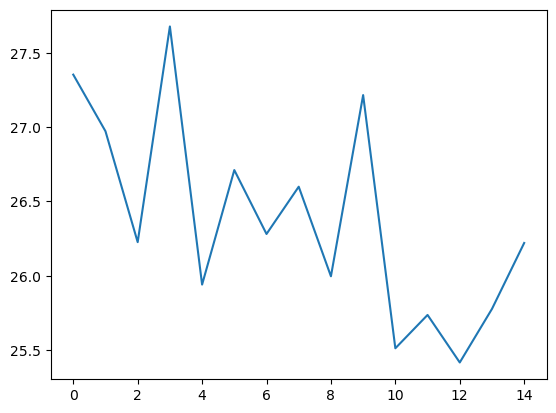

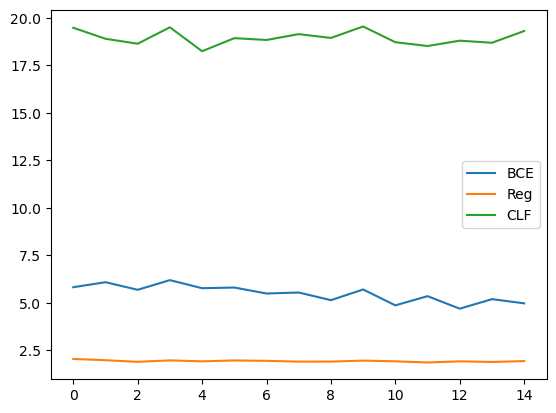

In [ ]:
loss_throughout = []
for i in loss_through_epochs: loss_throughout.extend(i)
plt.plot(loss_throughout)
plt.show()
save = True
if save:
    torch.save(net1, "net1")
    with open("bce_loss", "w") as fp: json.dump(bce_loss, fp)
    with open("reg_loss", "w") as fp: json.dump(reg_loss, fp)
    with open("clf_loss", "w") as fp: json.dump(clf_loss, fp)

plt.plot(bce_loss , label = "BCE")
plt.plot(reg_loss , label = "Reg")
plt.plot(clf_loss , label = "CLF")
plt.legend()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

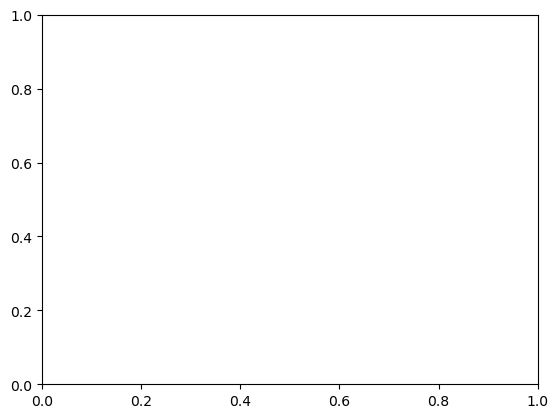

In [ ]:
plt.plot(bce_loss , label = "BCE")
plt.plot(reg_loss , label = "Reg")
plt.plot(clf_loss , label = "CLF")
plt.legend()
plt.show()

In [ ]:
dataloader_test = myDataset("val",img_annotations_val,cell_length,class_map,anchor_boxes)

Number of cells in row and col = 8
Cell length = 32
Number of total yolo cells = 64


In [ ]:
def get_object_info_from_net_output(yolo_tensor):
    #first get the cell x, y then the anchor box index

IndentationError: expected an indented block (719137962.py, line 3)

In [ ]:
loader_test = torch.utils.data.DataLoader(dataloader_test, batch_size=1, shuffle=True)
for image , yolo_tensor in loader_test:
    #print(yolo_tensor.shape)
    #yolo_tensor[0][0][0][0] = torch.tensor([1,2,3,4,5,6,7,8])
    index_img = np.where(yolo_tensor[0][:,:,:,0] == 1)
    object_info = []
    print("TRUE VALUES")
    for i in range(len(index_img[0])):
        object_info.append([index_img[0][i] , index_img[1][i] , index_img[2][i]])
        print(index_img[0][i] , index_img[1][i] , index_img[2][i])
        print(yolo_tensor[0 ,index_img[0][i] , index_img[1][i] , index_img[2][i],5:])
    
    print("==============================================================")
    
    image = image.to(device)
    output_tensor = net1(image)
    print(output_tensor.shape)
    output_tensor = torch.reshape(output_tensor[0] , [8,8,11,8])
    #output_tensor[:,:,:,5:] = nn.Softmax(output_tensor[:,:,:,5:])
    output_tensor = output_tensor.cpu()
    output_tensor = output_tensor.detach().numpy()
    max_values = np.sort(output_tensor[:,:,:,0].flatten())
    print(max_values.shape)
    print(max_values[-5:])
    for val in max_values[-10:]:
        index_max_prob = np.where(output_tensor[:,:,:,0] == val)
        print(index_max_prob)
        print("yolo vector for that index = ")
        print(output_tensor[index_max_prob[0],index_max_prob[1],index_max_prob[2],:])
        
    #print(output_tensor[0,3,:,:])
    #print(output_tensor[cell[0][0] , cell[1][0] , anchor[0]])
    #print(output_tensor.shape)
    break

TRUE VALUES
2 4 1
tensor([1., 0., 0.])
torch.Size([1, 5632])
(704,)
[4.2527285 6.0260696 6.080739  6.4880056 6.5723286]
(array([3], dtype=int64), array([5], dtype=int64), array([8], dtype=int64))
yolo vector for that index = 
[[ 3.66797    -0.09542598  0.08949031  1.8686155   1.1525036  -1.1574074
   0.65812373  0.23056608]]
(array([3], dtype=int64), array([4], dtype=int64), array([10], dtype=int64))
yolo vector for that index = 
[[ 3.6760406  -0.11252004  0.02247219  1.295671    1.0682604   0.35468647
  -0.47556725 -0.04892188]]
(array([4], dtype=int64), array([4], dtype=int64), array([10], dtype=int64))
yolo vector for that index = 
[[ 3.6931345   0.15114518  0.07162818  1.3453138   1.0818002   0.24841845
  -0.37672773  0.00451373]]
(array([5], dtype=int64), array([3], dtype=int64), array([8], dtype=int64))
yolo vector for that index = 
[[ 3.69369     0.04786545 -0.13827612  1.4491788   1.4884096  -0.16721869
  -0.5136654   0.55862975]]
(array([2], dtype=int64), array([4], dtype=int6

In [ ]:
num_correct = 0
total = 0
model.eval()
preds_cf = []
labels_cf = []
all_iou = 0.0
with torch.no_grad():
    for data, labels, bbox in test_loader:
        data = data.to(device=device)
        labels = labels.to(device=device)
        bbox = bbox.to(device=device)

        predictions, bbox_pred= model(data)

        predictions = [[1 if max(i)==j else 0 for j in i ] for i in predictions]
        pred_cf = class_map_rev[predictions[0].index(max(predictions[0]))]
        #print(pred_cf)
        preds_cf.append(pred_cf)
        #predictions = predictions.to(device=device)

        labels = labels.tolist()
        label_cf = class_map_rev[labels[0].index(max(labels[0]))]
        #print(f"label = {label_cf}")
        labels_cf.append(label_cf)

        #print(labels)
        #print(predictions == labels)
        #num_correct += (predictions == labels).sum()
        if predictions == labels:
            num_correct += 1
        #total += labels.size(0)
        total += 1
        #if total==1000:
        #    print(num_correct/total)
        #print(bbox_pred.tolist()[0])
        #print(bbox)

        #iou = calculate_iou(bbox[0],bbox_pred[0])
        iou = torchvision.ops.complete_box_iou(bbox,bbox_pred)

        all_iou = all_iou+iou

    #total = len(loader_test.dataset)
    accuracy = float(num_correct)/float(total)*100
    iou_accuracy = all_iou/float(total)
    print(f"Test Accuracy of the classification model: {accuracy:.2f} | regression model: {iou_accuracy}")
    return accuracy, iou_accuracy, labels_cf , preds_cf